In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import boxcox
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.datasets import load_airline
from sktime.performance_metrics.forecasting import  mean_absolute_percentage_error
#from sktime.utils.validation.forecasting import check_spilt_ratio
from sktime.forecasting.model_selection import temporal_train_test_split


# Load the data
m3_full=[8000,5120,4720,7020,3840,7360,5040,10800,6580,8520,9460,7560,7060,4560,4660,6040, 4260,5840,5020,
       10040,10060,9100,5840,6660,5680,5820, 3280, 3000,3800,6040,5040,7100,8140,6820,9000,6840,5020,
       3020,6960,3980,3660,2740,4760,8520,4220,7160,7040,4640,7440,3900,6800,4840,3080,5220,3840,2860,
       6780,5480,3700,4460,4180,4520,3900,3580,2120,4560,4500,5660,4240,10160,7500,7180,7800,5240,5480,
       3900,2920,4100,4540,	2520,4920,3080,2800,2160,3500,3420,3480,1900,2220,2620,5160,2520,4740,3380,3380,
       2640,3640,4840,1700,2660,2920,1860,3140,3360,4400,4760,5980,3980,4040,4440,1340,1740,2420,4380,4600,3800,
       3020,4920,4040,2960,4220,1660,2280,1600,2940,2960]

y= pd.Series(
    m3_full, index=pd.date_range("1984-10-1", periods=len(m3_full), freq="M"), name="m3_full")

print(y)
# Apply the Box-Cox transformation
y_transformed, lambda_ = boxcox(y)

# Decompose the transformed data using STL decomposition from statsmodels
result = seasonal_decompose(y_transformed, model='additive',period=12)

fig=result.plot()
trend = result.trend
seasonal = result.seasonal
residual=result.resid
residual

df=pd.DataFrame(residual,columns=["residual"],index=pd.date_range("1984-10-1", periods=len(m3_full), freq="M"))
df
# Split the decomposed data into training and test sets using temporal_train_test_split

n_test = 12

#train, test = temporal_train_test_split(pd.DataFrame(residual), test_size=n_test)

# Fit the ETS model
#model = ExponentialSmoothing()
#model.fit(train)




In [ ]:
print(train)

In [ ]:
pd.DataFrame(residual.T)

In [ ]:
# Define the bootstrapping function
def bootstrap_prediction(model, test, n_test, n_train, n_samples):
    n = n_test + n_train
    indices = np.random.randint(0, n - n_train, (n_samples, n_train))
    bootstrapped_predictions = []
    for index in indices:
        bootstrapped_model = ExponentialSmoothing()
        bootstrapped_model.fit(train[index])
        bootstrapped_prediction = bootstrapped_model.predict(n_test)
        bootstrapped_predictions.append(bootstrapped_prediction)
    bootstrapped_predictions = np.array(bootstrapped_predictions)
    return bootstrapped_predictions

# Use the bootstrap method with moving block bootstrap
n_samples = 100
bootstrapped_predictions = bootstrap_prediction(model, test, n_test, 
                                                 len(train), n_samples)

# Inverse the STL decomposition to get the predictions in transformed scale
bootstrapped_predictions = result.seasonal + bootstrapped_predictions * result.trend

# Inverse the Box-Cox transformation to get the predictions in original scale
bootstrapped_predictions = np.power(bootstrapped_predictions, 1/lambda_)

# Calculate the mean absolute percentage error (MAPE)
mape = mean_absolute_percentage_error(test, bootstrapped_predictions)
print("Mean Absolute Percentage Error",mape)

In [ ]:
from sktime.utils.validation.forecasting import check_spilt_ratio

In [ ]:
from sktime.performance_metrics.forecasting import  mean_absolute_percentage_error

In [ ]:
import random

# Function to generate random points within a square
def generate_random_point():
    x = random.uniform(0, 1)
    y = random.uniform(0, 1)
    return x, y

# Function to calculate the value of π using the Monte Carlo method
def calculate_pi(num_samples):
    inside_circle = 0
    for _ in range(num_samples):
        x, y = generate_random_point()
        # Check if the point lies inside the circle
        if x**2 + y**2 <= 1:
            inside_circle += 1
    return (inside_circle / num_samples) * 4

# Number of samples to generate
num_samples = 100000

# Calculate the value of π using the Monte Carlo method
approx_pi = calculate_pi(num_samples)

# Print the result
print("The approximate value of π is:", approx_pi)


In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import power_transform
from sktime.datasets import load_airline
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.transformations.series.boxcox import BoxCoxTransformer
from sktime.utils.validation.panel import check_X, check_X_y
#from sktime.utils.validation import check_cv
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

# Load the airline dataset
y= load_airline()
print(y)
# Check if data has missing values
X = check_X(y)

# Perform Box-Cox transformation
box_cox = BoxCoxTransformer()
X_transformed = box_cox.fit_transform(X)

# Perform STL decomposition
stl = sm.tsa.seasonal_decompose(X_transformed, period=12)
stl_residual = stl.resid

# Split data into training and testing
X_train, X_test, y_train, y_test = temporal_train_test_split(stl_residual, test_size=0.3)

# Perform bootstrapping on training data
def bootstrap_residual(residual, sample_size, iterations, random_seed=None):
    np.random.seed(random_seed)
    bootstrapped_residuals = []
    for i in range(iterations):
        bootstrapped_residual = np.random.choice(residual, size=sample_size, replace=True)
        bootstrapped_residuals.append(bootstrapped_residual)
    return np.array(bootstrapped_residuals)

bootstrapped_residuals = bootstrap_residual(stl_residual, sample_size=len(y_train), iterations=100)

# Train and evaluate multiple ETS models
models = ['Additive', 'Multiplicative', 'Additive Holt-Winters', 'Multiplicative Holt-Winters']
scores = []
for model in models:
    ets = ExponentialSmoothing(trend=model)
    ets.fit(y_train)
    y_pred = ets.predict(fh)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    scores.append(mape)

# Choose the model with the lowest MAPE
best_model = models[np.argmin(scores)]

print("Best ETS model is: ", best_model)


In [ ]:
from sktime.datasets import load_airline
data = load_airline()


In [ ]:
from scipy.stats import boxcox
transformed_data, _ = boxcox(data)


In [ ]:
import statsmodels.api as sm
decomposition = sm.tsa.seasonal_decompose(transformed_data, model='multiplicative',period=12)
residual = decomposition.resid


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(residual, transformed_data, test_size=0.3, shuffle=False)


In [ ]:
from sklearn.utils import resample
residual_bootstrapped = resample(residual, replace=True, n_samples=len(residual), random_state=1)


In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
model = ExponentialSmoothing(X_train, trend='add', seasonal='add', seasonal_periods=12).fit()
y_pred = model.predict(start=len(X_train), end=len(X_train)+len(X_test)-1)
print(y_pred)
from sklearn.metrics import mean_absolute_percentage_error
#mape = mean_absolute_percentage_error(y_test, y_pred)


In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt 
from sklearn.preprocessing import power_transform
from sktime.datasets import load_airline
from sktime.forecasting.model_selection import temporal_train_test_split
from scipy.stats import boxcox
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

# Load the airline dataset
y = load_airline()

# Check if data has missing values


# Perform Box-Cox transformation
y_transformed, lambda_ = boxcox(y)
print(lambda_)
# Perform STL decomposition
stl = sm.tsa.seasonal_decompose(y_transformed, model='additive', period=12)
plt.rcParams["figure.figsize"]=(30,15)
stl.plot()
plt.show()
stl_residual = stl.resid
# Split data into training and testing
y_train, y_test = temporal_train_test_split(stl_residual, test_size=0.3)
print(y_train, y_test)

In [ ]:
l = 24 # block size
B = 11 # number of bootstrapped series
T1=len(m3)+len(range(1,13))
fcast_h=list(range(1,13))

bt_m3 = pd.DataFrame(np.zeros((len(y),B)),index=m3.index) #
m3_fcast=pd.DataFrame(np.zeros((T1,B)),index=pd.date_range(start=m3.index[0],periods=T1,freq="M")) 

In [ ]:
def bootstrap_residual(residual, sample_size, iterations, random_seed=None):
    np.random.seed(random_seed)
    bootstrapped_residuals = []
    for i in range(iterations):
        bootstrapped_residual = np.random.choice(residual, size=sample_size, replace=True)
        bootstrapped_residuals.append(bootstrapped_residual)
    return np.array(bootstrapped_residuals)

bootstrapped_residuals = bootstrap_residual(stl_residual, sample_size=len(y_train), iterations=100)
pd.DataFrame(bootstrapped_residuals)

In [ ]:
bootstrapped_predictions = result.seasonal + bootstrapped_predictions * result.trend

# Inverse the Box-Cox transformation to get the predictions in original scale
bootstrapped_predictions = np.power(bootstrapped_predictions, 1/lambda_)


/Users/heng/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


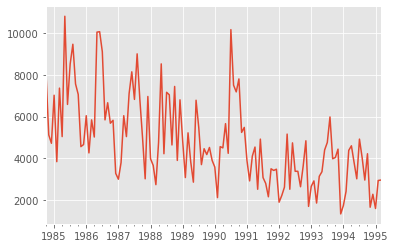

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import STL
from scipy.stats import boxcox 
from scipy.special import inv_boxcox
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sktime.forecasting.ets import AutoETS 
from itertools import product
import warnings 
from scipy.special import inv_boxcox
plt.style.use('ggplot')

m3_full=[8000,5120,4720,7020,3840,7360,5040,10800,6580,8520,9460,7560,7060,4560,4660,6040, 4260,5840,5020,
       10040,10060,9100,5840,6660,5680,5820, 3280, 3000,3800,6040,5040,7100,8140,6820,9000,6840,5020,
       3020,6960,3980,3660,2740,4760,8520,4220,7160,7040,4640,7440,3900,6800,4840,3080,5220,3840,2860,
       6780,5480,3700,4460,4180,4520,3900,3580,2120,4560,4500,5660,4240,10160,7500,7180,7800,5240,5480,
       3900,2920,4100,4540,	2520,4920,3080,2800,2160,3500,3420,3480,1900,2220,2620,5160,2520,4740,3380,3380,
       2640,3640,4840,1700,2660,2920,1860,3140,3360,4400,4760,5980,3980,4040,4440,1340,1740,2420,4380,4600,3800,
       3020,4920,4040,2960,4220,1660,2280,1600,2940,2960]

###一維度 dataframe tX1

m3_full= pd.Series(
    m3_full, index=pd.date_range("1984-10-1", periods=len(m3_full), freq="M"), name="m3_full")


T=len(m3_full)
m3_full.plot()
plt.show(block=True)




/var/folders/4p/_w7sb0h97x989ymb8f68ts_h0000gn/T/ipykernel_1023/2590131912.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  nb=np.int(n/l)+2


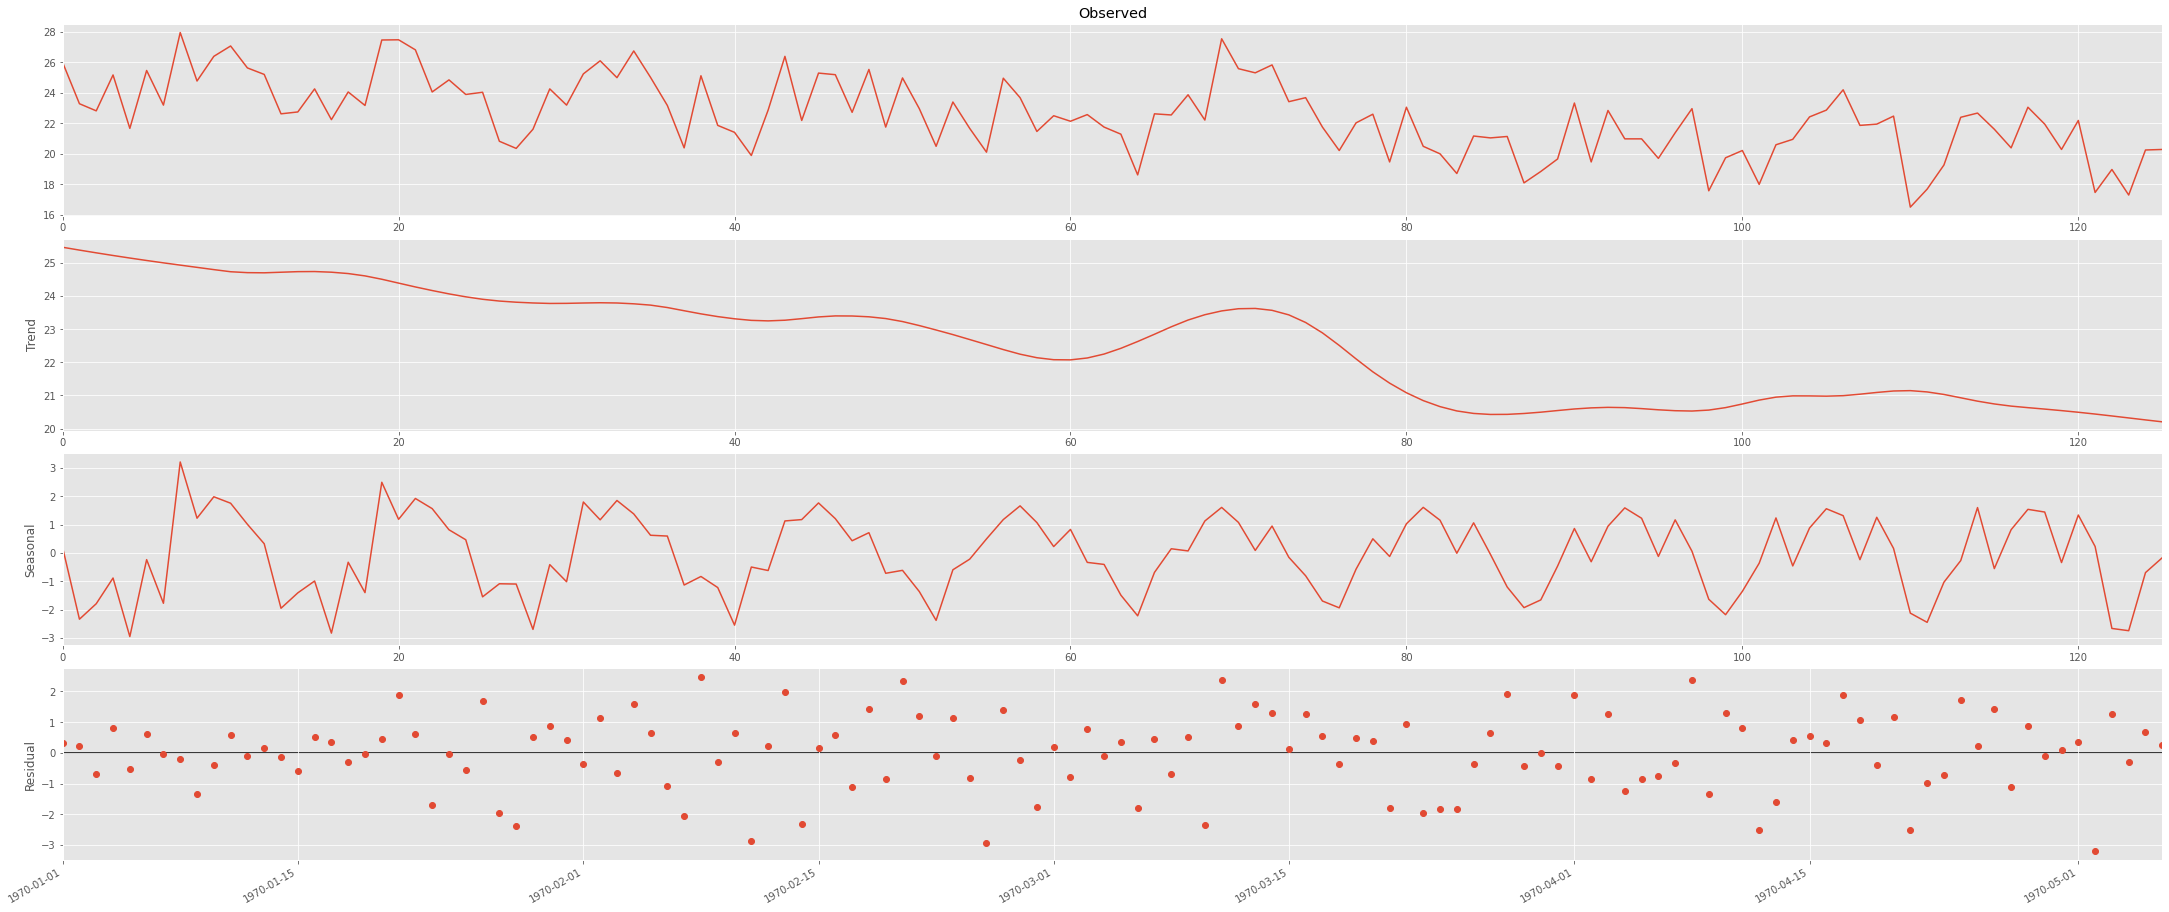

In [2]:
m3_full_transformed, lambda_ = boxcox(m3_full)
stl = STL(m3_full_transformed, seasonal=13,period=12)
res=stl.fit()
trend = res.trend
seasonal = res.seasonal
plt.rcParams["figure.figsize"]=(30,15)
res.plot()
def mbb(x,l):  #l block size
    n=len(x) #the length of data
    nb=np.int(n/l)+2
    idx=np.random.randint(n-l,size=nb)
    z=[]
    for ii in idx:
        z=z+list(x[ii:ii+l]) 
    z=z[np.random.randint(l):]
    z=z[:n]
    return(z)

z =mbb(res.resid,8)
z=pd.Series(z,index=m3_full.index)
z.plot()
plt.show()

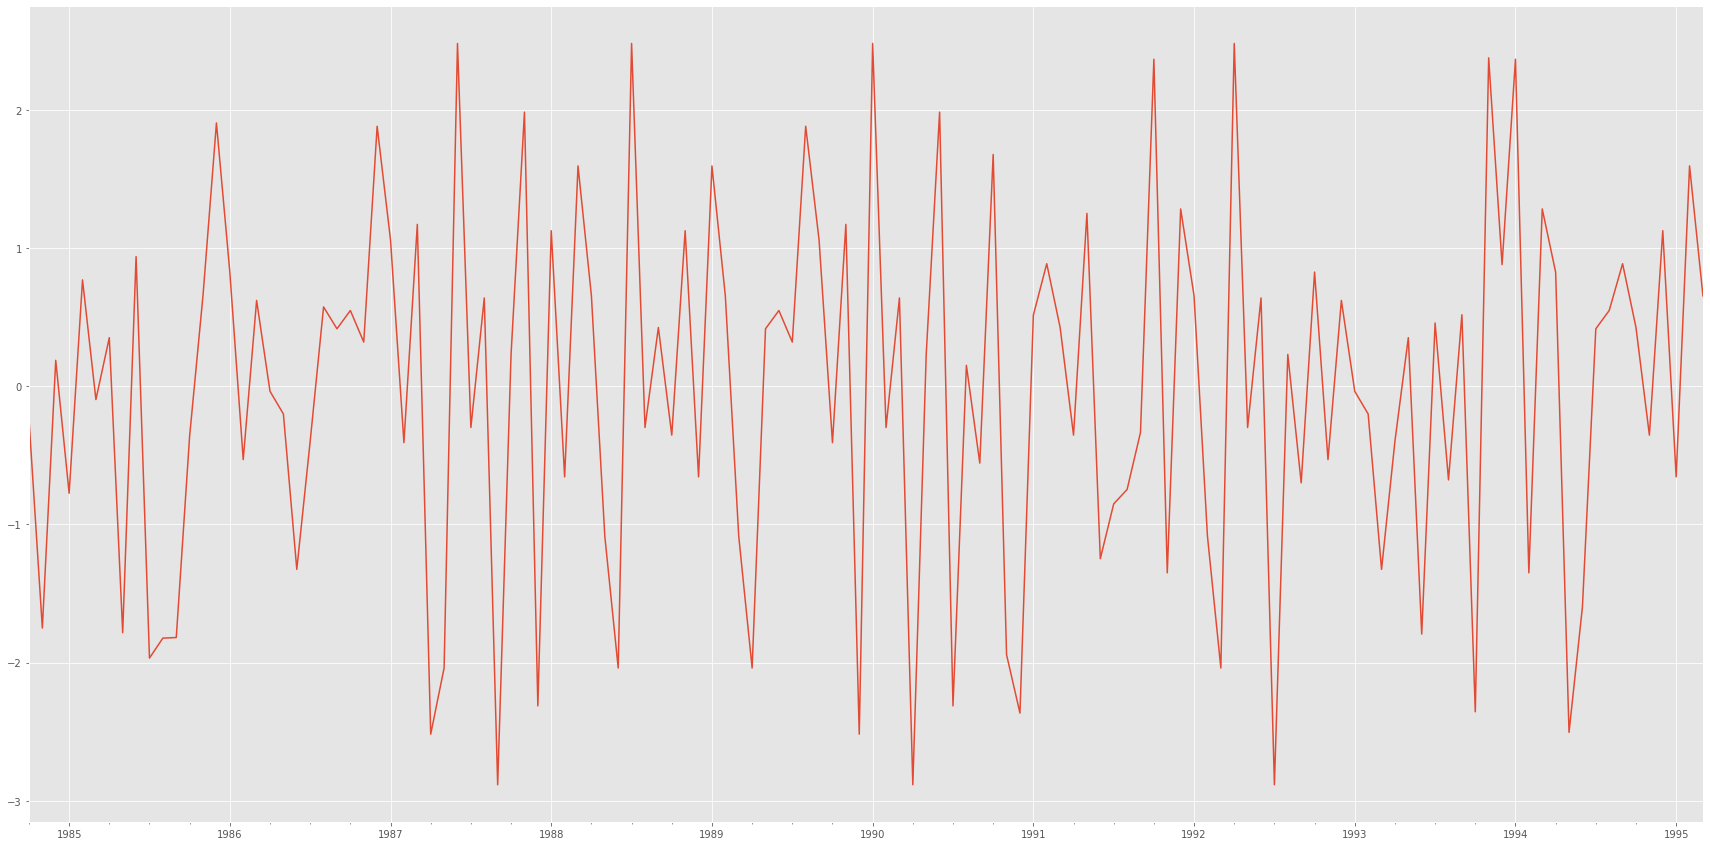

In [3]:
plt.rcParams["figure.figsize"]=(30,15)
z.plot()
plt.show(block=True)

In [4]:
#  moving block bootstrap
l = 24 # block size
B = 11 # number of bootstrapped series
T1=len(m3_full)+len(range(1,13))
fcast_h=list(range(1,13))

bt_m3_full = pd.DataFrame(np.zeros((len(m3_full),B)),index=m3_full.index) #
m3_full_fcast=pd.DataFrame(np.zeros((T1,B)),index=pd.date_range(start=m3_full.index[0],periods=T1,freq="M")) 

for bb in range(B):
    z = mbb(res.resid,l) 
    bt_m3_full.iloc[:,bb]= np.array(z)+trend+seasonal




/var/folders/4p/_w7sb0h97x989ymb8f68ts_h0000gn/T/ipykernel_1023/2590131912.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  nb=np.int(n/l)+2
/var/folders/4p/_w7sb0h97x989ymb8f68ts_h0000gn/T/ipykernel_1023/2590131912.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the r

In [5]:
inv_box_cox =inv_boxcox(bt_m3_full, lambda_)
inv_box_cox 


,0,1,2,3,4,5,6,7,8,9,10
1984-10-31,5138.887776,8240.411823,7317.929146,8402.442701,9282.052510,7887.086678,8167.359494,8066.930018,7762.548243,7239.670518,10941.448000
1984-11-30,7318.988523,5726.243998,3589.149256,2892.985255,5666.887088,6256.016835,4363.645614,3566.618487,6115.975581,4882.174170,5719.877677
1984-12-31,6182.990032,5728.934400,5502.680336,5543.035253,3399.056024,3399.056024,5818.990046,6242.975274,5857.528377,5756.729499,6947.459728
1985-01-31,7931.746079,5775.941904,5377.337417,8437.782987,4661.221899,4661.221899,4070.269017,7578.656522,5768.762587,8318.314487,7578.656522
1985-02-28,5315.815404,5155.958800,4847.151403,2737.669838,4554.444685,4554.444685,6369.392461,4332.952366,4617.363102,4714.591913,4332.952366
...,...,...,...,...,...,...,...,...,...,...,...
1994-11-30,4587.271268,3757.347918,3270.885394,2168.750513,4160.657123,2796.548000,3010.239714,2327.735134,2933.078063,4046.406870,2637.129723
1994-12-31,1036.028921,1718.604784,2291.885492,1023.138245,1452.855835,1996.344185,2007.785828,1915.646619,1753.103576,2087.361982,1492.077345
1995-01-31,1757.534260,1729.986975,1916.520992,1899.407776,2763.367712,1164.547742,871.119147,1505.551631,1550.935164,956.329023,2441.812226
1995-02-28,2879.103918,2758.008217,2393.285685,3060.460129,3255.140990,2551.575233,2693.377649,3554.480926,3683.156117,1851.705699,2696.393720


this is mape  0.5876304008396216
this is mape  0.4308968000517234
this is mape  0.252016326672227
this is mape  0.41065564339882504
this is mape  0.28443526964538834
this is mape  0.33758246403854103
this is mape  0.3865665266172526
this is mape  0.3980188304914627
this is mape  0.3200044644682559
this is mape  0.27544194293481633
this is mape  0.26609988170150517
model no 2


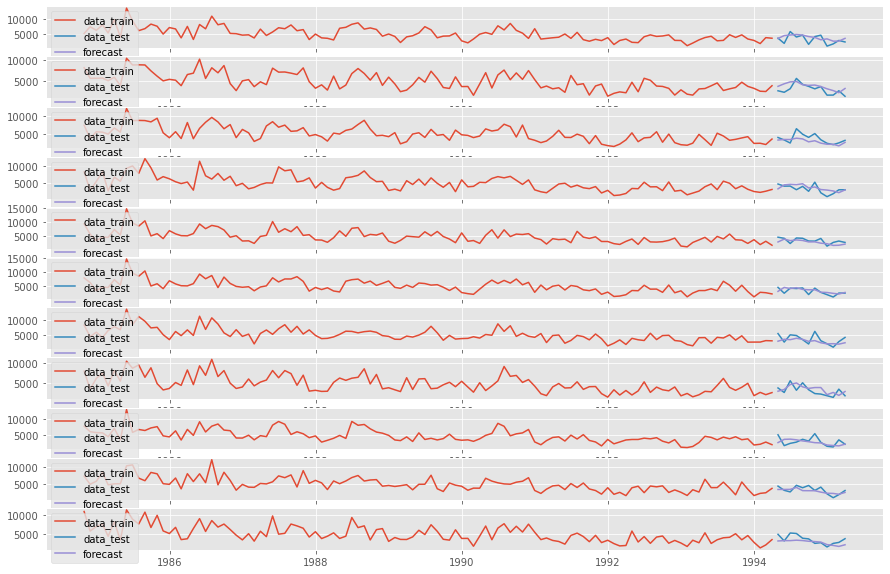

In [63]:

from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
MAPEs = []
for bb in range(B):
    inv_box_cox_series = inv_box_cox.iloc[:,bb]
    X_train, X_test = inv_box_cox_series[:-12], inv_box_cox_series[-12:]
    autoets = AutoETS(auto=True,n_jobs=-1,sp=12,maxiter=5000)
    autoets.fit(X_train)
    y_pred = autoets.predict(fcast_h)
    mape = mean_absolute_percentage_error(X_test, y_pred)
    print("this is mape ",mape)
    MAPEs.append(mape)
    plt.subplot(B, 1, bb + 1)
    plt.plot(X_train, label="data_train")
    plt.plot(X_test,label="data_test")
    plt.plot(X_test.index, y_pred, label="forecast")
    plt.legend()
best_model = MAPEs.index(min(MAPEs))
print("model no",best_model)
plt.show()




In [58]:

for bb in range(B):
    inv_box_cox_series = inv_box_cox.iloc[:,bb]
    X_train, X_test = inv_box_cox_series[:-12], inv_box_cox_series[-12:]
    autoets = AutoETS(auto=True,n_jobs=-1,sp=12,maxiter=5000)
    autoets.fit(X_train)
    y_pred = autoets.predict(fcast_h)
    print(autoets.summary())


                                 ETS Results                                  
Dep. Variable:                      y   No. Observations:                  114
Model:                       ETS(MNM)   Log Likelihood                -974.220
Date:                Thu, 09 Feb 2023   AIC                           1980.440
Time:                        12:45:46   BIC                           2024.219
Sample:                    10-31-1984   HQIC                          1998.207
                         - 03-31-1994   Scale                            0.064
Covariance Type:               approx                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.2001      0.052      3.870      0.000       0.099       0.301
smoothing_seasonal   7.999e-05        nan        nan        nan         nan         nan
initial_level   

                                 ETS Results                                  
Dep. Variable:                      4   No. Observations:                  114
Model:                       ETS(MAM)   Log Likelihood                -967.778
Date:                Thu, 09 Feb 2023   AIC                           1971.556
Time:                        12:45:47   BIC                           2020.807
Sample:                    10-31-1984   HQIC                          1991.544
                         - 03-31-1994   Scale                            0.067
Covariance Type:               approx                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.0010        nan        nan        nan         nan         nan
smoothing_trend         0.0010        nan        nan        nan         nan         nan
smoothing_season

                                 ETS Results                                  
Dep. Variable:                      7   No. Observations:                  114
Model:                       ETS(MNM)   Log Likelihood                -976.728
Date:                Thu, 09 Feb 2023   AIC                           1985.455
Time:                        12:45:48   BIC                           2029.234
Sample:                    10-31-1984   HQIC                          2003.223
                         - 03-31-1994   Scale                            0.069
Covariance Type:               approx                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.1072      0.037      2.871      0.004       0.034       0.180
smoothing_seasonal      0.3373      0.091      3.697      0.000       0.158       0.516
initial_level   

                                 ETS Results                                  
Dep. Variable:                     10   No. Observations:                  114
Model:                       ETS(MAM)   Log Likelihood                -982.072
Date:                Thu, 09 Feb 2023   AIC                           2000.143
Time:                        12:45:49   BIC                           2049.395
Sample:                    10-31-1984   HQIC                          2020.132
                         - 03-31-1994   Scale                            0.080
Covariance Type:               approx                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.0001      0.048      0.002      0.998      -0.094       0.094
smoothing_trend          1e-08      0.004    2.7e-06      1.000      -0.007       0.007
smoothing_season

2

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

MAPEs = []
plt.figure(figsize=(15,10))
for bb in range(B):
    inv_box_cox_series = inv_box_cox.iloc[:,bb]
    X_train, X_test = inv_box_cox_series[:-12], inv_box_cox_series[-12:]
    autoets = AutoETS(auto=True,n_jobs=-1,sp=12,maxiter=5000)
    autoets.fit(X_train)
    y_pred = autoets.predict(fcast_h)
    mape = mean_absolute_percentage_error(X_test, y_pred)
    print("this is mape ",mape)
    MAPEs.append(mape)
    plt.subplot(B, 1, bb + 1)
    plt.plot(inv_box_cox_series, label="train and test")
    plt.plot(X_test.index, y_pred, label="forecast")
    plt.legend()
best_model = MAPEs.index(min(MAPEs))
plt.show()


0.48807503195531493

1994-04-30    4859.204860
1994-05-31    3093.722631
1994-06-30    5210.841231
1994-07-31    5076.626074
1994-08-31    3813.099758
1994-09-30    3641.242729
1994-10-31    2445.623512
1994-11-30    2637.129723
1994-12-31    1492.077345
1995-01-31    2441.812226
1995-02-28    2696.393720
1995-03-31    3692.751401
Freq: M, Name: 10, dtype: float64

In [ ]:
    tscv = TimeSeriesSplit(n_splits=3)
    for train_index, test_index in tscv.split(X_train):
        X_train_split, X_test_split = X_train[train_index], X_test[test_index]
        autoets = AutoETS()
        autoets.fit(X_train_split)
        y_pred = autoets.predict(fcast_h)
        mape = mean_absolute_percentage_error(X_test_split[-12:], y_pred)
        MAPEs.append(mape)
        
best_model = MAPEs.index(min(MAPEs))


1995-04-30    1.860071e+07
1995-05-31   -2.728095e+07
1995-06-30   -1.332699e+07
1995-07-31   -3.915327e+06
1995-08-31   -6.975905e+06
1995-09-30   -8.814826e+06
1995-10-31   -6.337557e+05
1995-11-30    9.292053e+06
1995-12-31   -4.562998e+06
1996-01-31    3.195363e+06
1996-02-29    8.794435e+06
1996-03-31    5.471444e+05
Freq: M, Name: 0, dtype: float64
                                 ETS Results                                  
Dep. Variable:                      y   No. Observations:                  126
Model:                       ETS(MAM)   Log Likelihood                -218.605
Date:                Thu, 09 Feb 2023   AIC                            473.210
Time:                        00:28:18   BIC                            524.263
Sample:                    10-31-1984   HQIC                           493.951
                         - 03-31-1995   Scale                            0.004
Covariance Type:               approx                                         
           

                                 ETS Results                                  
Dep. Variable:                      3   No. Observations:                  126
Model:                       ETS(AAA)   Log Likelihood                -229.662
Date:                Thu, 09 Feb 2023   AIC                            495.324
Time:                        00:28:20   BIC                            546.377
Sample:                    10-31-1984   HQIC                           516.066
                         - 03-31-1995   Scale                            2.242
Covariance Type:               approx                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.0001        nan        nan        nan         nan         nan
smoothing_trend          1e-08      0.003   3.64e-06      1.000      -0.005       0.005
smoothing_season

                                 ETS Results                                  
Dep. Variable:                      6   No. Observations:                  126
Model:                       ETS(MAM)   Log Likelihood                -232.187
Date:                Thu, 09 Feb 2023   AIC                            500.375
Time:                        00:28:21   BIC                            551.428
Sample:                    10-31-1984   HQIC                           521.116
                         - 03-31-1995   Scale                            0.005
Covariance Type:               approx                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.0001        nan        nan        nan         nan         nan
smoothing_trend          1e-08      0.004   2.63e-06      1.000      -0.007       0.007
smoothing_season

1995-04-30    6.311934e+06
1995-05-31    8.760355e+06
1995-06-30    1.416297e+07
1995-07-31    1.860827e+07
1995-08-31    2.122304e+07
1995-09-30    2.736818e+07
1995-10-31    3.455820e+07
1995-11-30    3.567980e+07
1995-12-31    4.169592e+07
1996-01-31    4.430165e+07
1996-02-29    4.962288e+07
1996-03-31    4.895974e+07
Freq: M, Name: 9, dtype: float64
                                 ETS Results                                  
Dep. Variable:                      9   No. Observations:                  126
Model:                       ETS(MAM)   Log Likelihood                -233.736
Date:                Thu, 09 Feb 2023   AIC                            503.472
Time:                        00:28:23   BIC                            554.525
Sample:                    10-31-1984   HQIC                           524.213
                         - 03-31-1995   Scale                            0.005
Covariance Type:               approx                                         
           

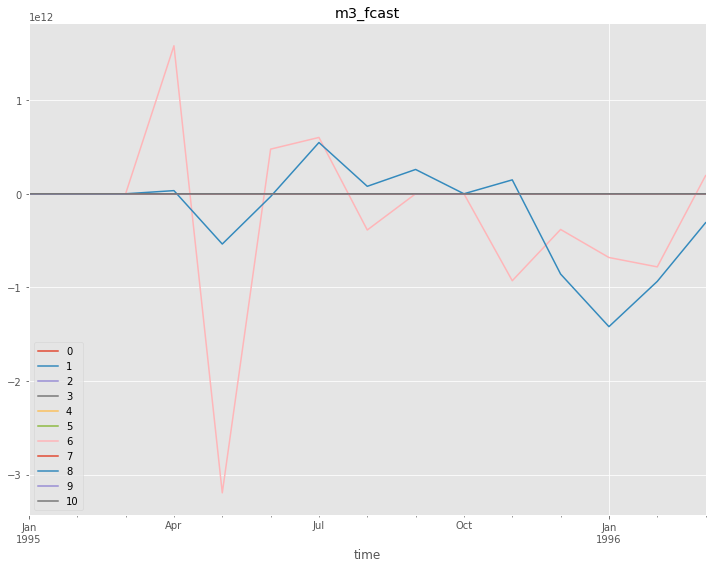

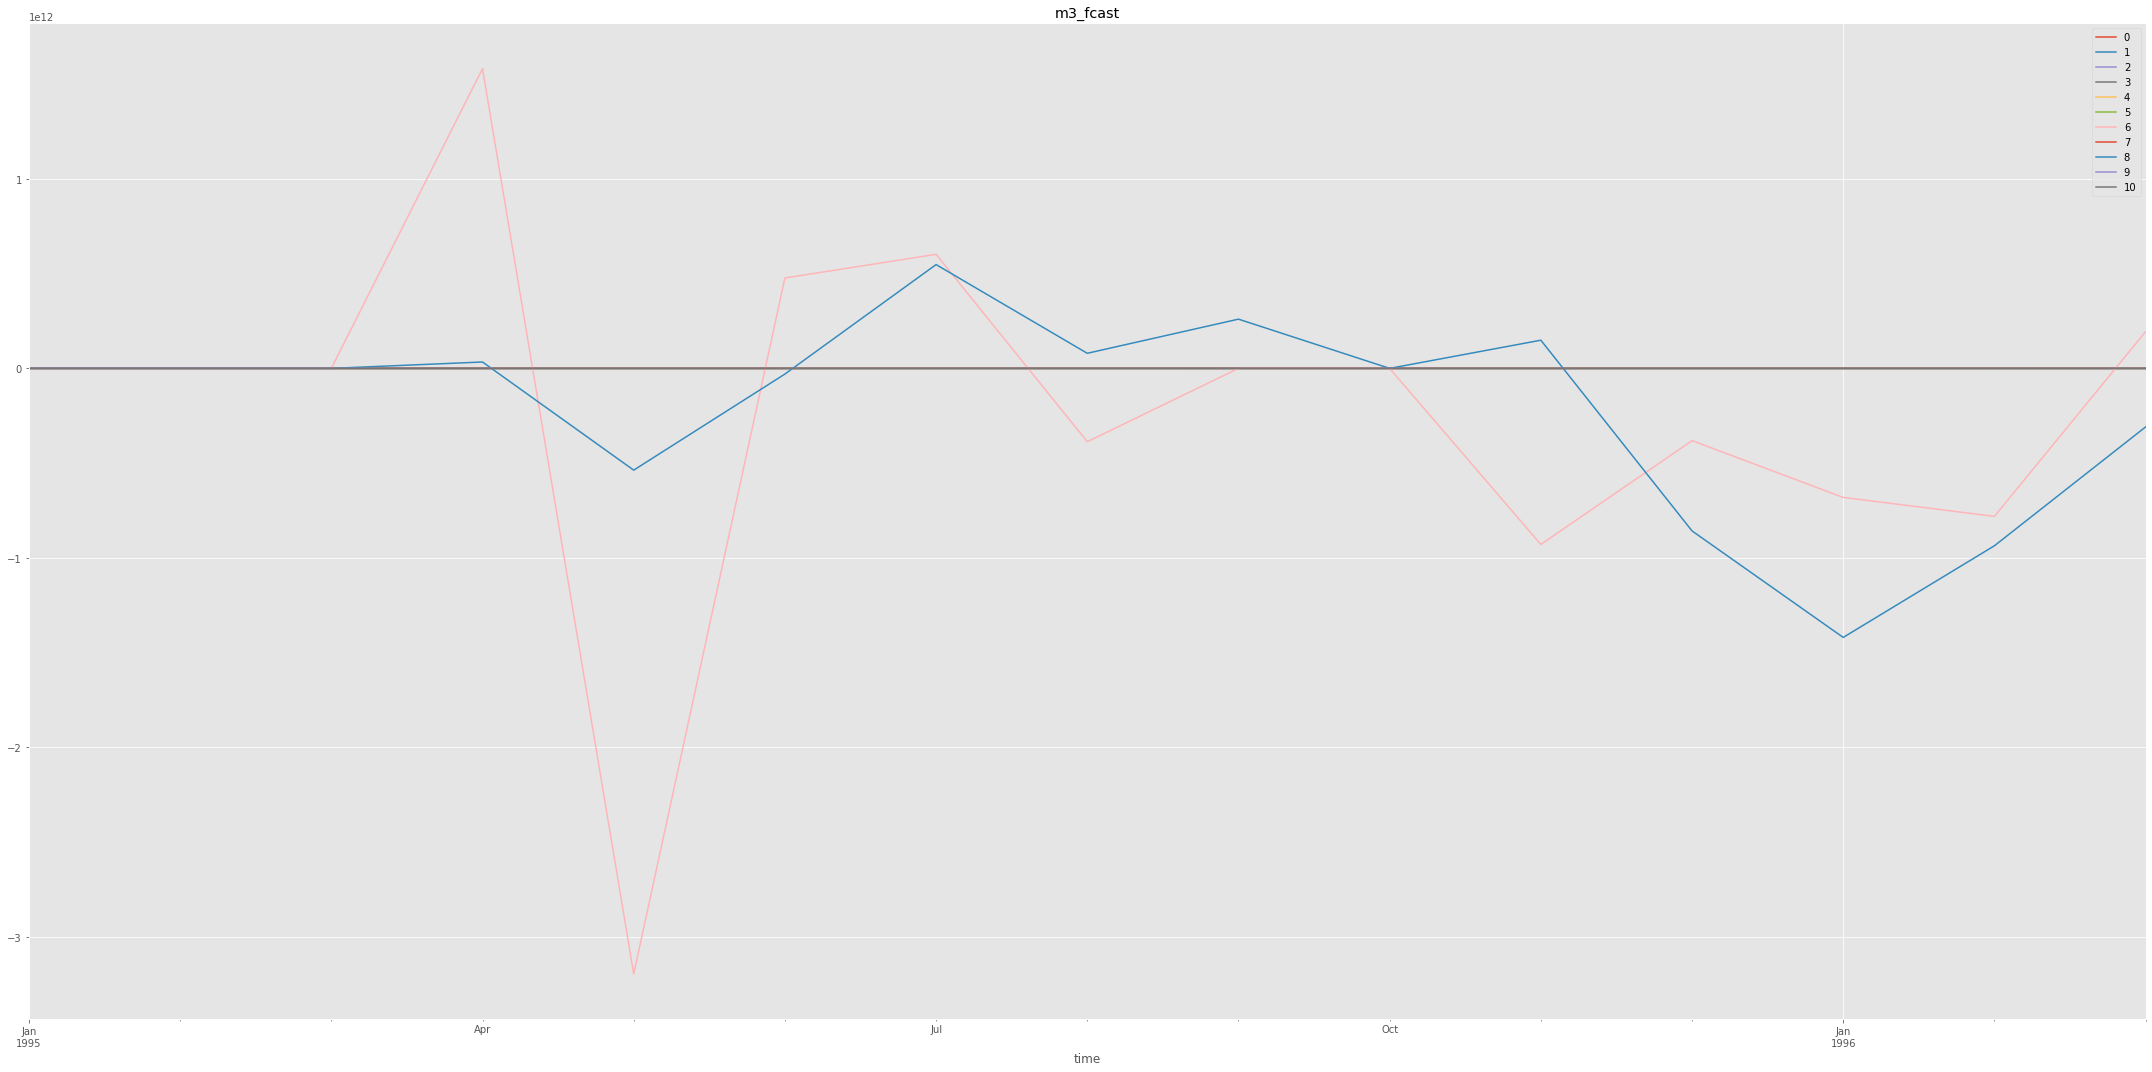